In [18]:
# test code works after changes for serialization 

import librosa

from ddc_onset import FRAME_RATE, compute_onset_salience, find_peaks

# audio is (5864816,) in [-1, 1]
# audio, sr = librosa.load('loop.mp3', sr=44100, mono=True)

audio, sr = librosa.load('loop.mp3', sr=44100, mono=True)


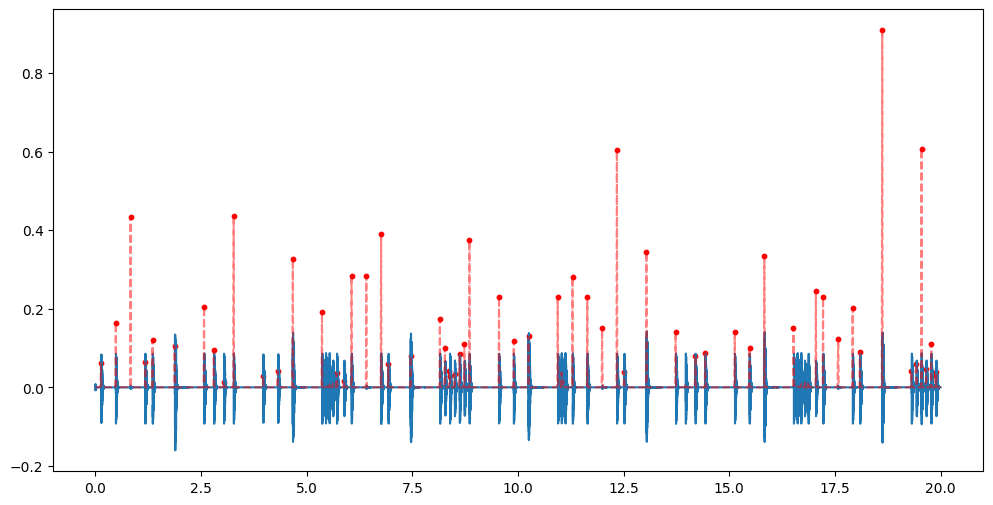

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from pysndfx import AudioEffectsChain
from ddc_onset import FRAME_RATE, compute_onset_salience, find_peaks

# Create an AudioEffectsChain with the supplied effects
fx = (
    AudioEffectsChain()
)

# Apply the effects and return the results
audio = fx(audio)


audio2 = audio[-int(20 * sr):]

t = np.arange(len(audio2)) / sr

fig, ax = plt.subplots(figsize=(12, 6))


plt.plot(t, audio2)

# onset salience is (13301,) in [0, 1]
onset_salience = compute_onset_salience(audio2, sr)
plt.plot(np.arange(len(onset_salience)) / FRAME_RATE, onset_salience, color='red', alpha=0.5, linestyle='dashed')

# peaks 
peaks = find_peaks(onset_salience)
peaks = peaks[onset_salience[peaks] > 0.01]
plt.scatter(peaks / FRAME_RATE, onset_salience[peaks], color='red', s=10)

# play audio
import IPython.display as ipd
ipd.Audio(filename='loop.mp3')

In [9]:
type(onset_salience)

numpy.ndarray

In [10]:
import torch
from ddc_onset import Difficulty

import numpy as np
from typing import Optional

from ddc_onset.cnn import SpectrogramNormalizer, PlacementCNN
from ddc_onset.spectral import SpectrogramExtractor

class DDC_Onset(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.extractor = SpectrogramExtractor()
        self.normalizer = SpectrogramNormalizer()
        self.placement_cnn = PlacementCNN()
    
    def forward(self, audio: np.ndarray, difficulty: Difficulty = Difficulty.CHALLENGE):
        audio = torch.tensor(audio, device=self.device).view(1, -1)
        difficulties = torch.tensor(
            [difficulty.value], device=self.device, dtype=torch.int64
        )
        spectrogram = self.extractor(audio)
        onset_salience = self.placement_cnn(self.normalizer(spectrogram[0]), difficulties)[0]
        return onset_salience.cpu().numpy()

    def find_peaks(self, onset_salience: np.ndarray):
        try:
            from scipy.signal import argrelextrema
        except ImportError:
            raise Exception(
                "Scipy required for finding peaks. Please install scipy with `pip install scipy`."
            )
        onset_salience_smoothed = np.convolve(onset_salience, np.hamming(5), "same")
        peaks = argrelextrema(onset_salience_smoothed, np.greater_equal, order=1)[0]
        return peaks
                
def compute_onset_salience(
    audio: np.ndarray,
    sr: int,
    device: Optional[torch.device] = None,
    difficulty=Difficulty.CHALLENGE,
):
    """Computes onset salience function from audio.

    Args:
        audio: Audio as float32 [num_samples].
        sr: Sample rate of audio. Resamples if not 44.1kHz.
        device: Device to run on. If None, run on CPU.
        difficulty: DDR difficulty label. For general onset detection, the default of Difficulty.CHALLENGE is recommended.
    Returns:
        Onset salience function as float32 [num_frames], frame rate of 100Hz.
    """
    # Check and maybe resample input
    if audio.dtype != np.float32:
        raise TypeError()
    if audio.ndim != 1:
        # TODO: Support multichannel audio and/or batched audio.
        raise ValueError()
    if sr != 44100:
        raise ValueError()

    # Load models
    global _MODULE_SINGLETONS
    if _MODULE_SINGLETONS is None:
        _MODULE_SINGLETONS = (
            SpectrogramExtractor(),
            SpectrogramNormalizer(),
            PlacementCNN(),
        )
        _MODULE_SINGLETONS = tuple(model.eval() for model in _MODULE_SINGLETONS)
    if device is not None:
        _MODULE_SINGLETONS = tuple(model.to(device) for model in _MODULE_SINGLETONS)
    extract, normalize, place = _MODULE_SINGLETONS

    # Predict
    with torch.no_grad():
        audio = torch.tensor(audio, device=device).view(1, -1)
        difficulties = torch.tensor(
            [difficulty.value], device=device, dtype=torch.int64
        )
        spectrogram = extract(audio)
        # TODO: Batch support
        onset_salience = place(normalize(spectrogram[0]), difficulties)[0]
        return onset_salience.cpu().numpy()


def find_peaks(onset_salience: np.ndarray):
    """Finds peaks in onset salience function."""
    try:
        from scipy.signal import argrelextrema
    except ImportError:
        raise Exception(
            "Scipy required for finding peaks. Please install scipy with `pip install scipy`."
        )
    onset_salience_smoothed = np.convolve(onset_salience, np.hamming(5), "same")
    peaks = argrelextrema(onset_salience_smoothed, np.greater_equal, order=1)[0]
    return peaks